# Final Project EDA

Gaurav Anand, Shannon Paylor, Amamda West

## Data

For our project, we are using Virginia court [data](http://virginiacourtdata.org) from a Code for Charlottesville project with the LAJC. For our EDA, we only looked at data from 2019 circuit and district criminal court cases.

In [1]:
from pyspark.sql import SparkSession

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql import functions as F

import json
import pandas as pd
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

In [31]:
circuit = spark.read.csv("circuit_criminal_2019_anon_00.csv", header = True)

In [3]:
district = spark.read\
                .format("csv")\
                .option("header", "true")\
                .load("district_criminal_2019_anon_*.csv")

In [4]:
#most fields are strings, but wanted to create schema so that a few columns are numeric
fields = []
for f in json.loads(district.schema.json())["fields"]:
    if f["name"] in ['Fine', 'Costs', 'FineCostsDue', 'FineCostsPaid']:
        fields.append(StructField(f["name"], DoubleType(), True))
    else:
        fields.append(StructField.fromJson(f))

schema = StructType(fields)

In [60]:
district = spark.read.schema(schema)\
                .format("csv")\
                .option("header", "true")\
                .load("district_criminal_2019_anon_*.csv")

Number of records:

In [6]:
circuit.count()

224258

In [7]:
district.count()

1947066

Number of columns:

In [10]:
len(circuit.columns)

50

In [11]:
len(district.columns)

42

## Response Variable

We haven't yet decided what we will use as our response variable, as the Code for Charlottesville goals for the project are more focused on descriptive statistics. At the moment, the most probable choice for response variable is `HearingResult`.

Statistical summary of response variable:

In [73]:
hear = circuit.groupBy('HearingResult').agg(F.count(circuit.HearingResult).alias('count'))

hear.withColumn('percent', hear['count']/nrows_cir).show(40)

+--------------------+-----+--------------------+
|       HearingResult|count|             percent|
+--------------------+-----+--------------------+
|Deferred Disposition|   96|4.280783740156427E-4|
|Not Guilty By Rea...|  105|4.682107215796092E-4|
|Stet Process Dock...|  223|9.943903896405034E-4|
|           Continued|    1|4.459149729329611...|
|Drug Court, Conti...|   39|1.739068394438548...|
|        Carried Over|   24|1.070195935039106...|
|             Not Set|  914|0.004075662852607265|
|        Joint Motion|    7|3.121404810530728E-5|
|Ordered Into Drug...|   89|3.968643259103354E-4|
|           True Bill|  168|7.491371545273747E-4|
|Drug Court, Compl...|   82|3.656502778050281...|
|            Remanded|  289|0.001288694271776...|
|Show Cause Dismissed|  114|5.083430691435757E-4|
|No Longer Under A...|  234|0.001043441036663...|
|                null|    0|                 0.0|
|Revoked - Sentenc...|34714| 0.15479492370394812|
| Granted As Modified|  121| 5.39557117248883E-4|


In [74]:
hear = district.groupBy('HearingResult').agg(F.count(district.HearingResult).alias('count'))

hear.withColumn('percent', hear['count']/nrows_dis).show()

+-------------+-------+--------------------+
|HearingResult|  count|             percent|
+-------------+-------+--------------------+
|    Finalized|1333902|  0.6850830942556647|
|    Continued|    151|7.755258424727257E-5|
|       Waived| 552689| 0.28385735254993927|
|         null|      0|                 0.0|
+-------------+-------+--------------------+



## Predictor Variables

These may change somewhat, but the likely candidates for predictor variables are `Gender`, `Race`, `ChargeType`, `Class`, `ProbationType`, `Fine`, and `Costs`.

Statistical summary of potential predictor variables:

#### Gender

In [27]:
import numpy as np

In [22]:
nrows_cir = circuit.count()
nrows_dis = district.count()

In [33]:
sex = circuit.groupBy('Sex').agg(F.count(circuit.Sex).alias('count'))

sex.withColumn('percent', sex['count']/nrows_cir).show()

+------+------+------------------+
|   Sex| count|           percent|
+------+------+------------------+
|Female| 58850|0.2624209615710476|
|  Male|165408|0.7375790384289523|
+------+------+------------------+



#### Race

In [36]:
race = circuit.groupBy('Race').agg(F.count(circuit.Race).alias('count'))

race.withColumn('percent', race['count']/nrows_cir).show()

+--------------------+------+--------------------+
|                Race| count|             percent|
+--------------------+------+--------------------+
|                null|     0|                 0.0|
|             Unknown|    15|6.688724593994418E-5|
|Other (Includes N...|  2336|0.010416573767713972|
|American Indian O...|    84|3.745685772636873...|
|               White|130997|  0.5841352370929911|
|Asian Or Pacific ...|   775|0.003455841040230449|
|               Black| 88472|  0.3945098948532494|
|            Hispanic|  1033|0.004606301670397...|
+--------------------+------+--------------------+



In [63]:
district = district.filter(district.Race !='83/55 RECKLESS')\
                   .withColumn('Race', F.regexp_replace('Race', '\(Non-Hispanic\)', ''))\
                   .withColumn('Race', F.regexp_replace('Race', ' Caucasian', ''))

In [64]:
race = district.groupBy('Race').agg(F.count(district.Race).alias('count'))
#condense Black/Black (Non-Hispanic), White/White (Non-Hispanic), etc.

race.withColumn('percent', race['count']/nrows_dis).show(20, False)

+------------------------------------------+-------+---------------------+
|Race                                      |count  |percent              |
+------------------------------------------+-------+---------------------+
|Other(Includes Not Applicable, Unknown)   |24253  |0.01245617765396756  |
|Unknown                                   |4883   |0.00250787595284392  |
|American Indian                           |3713   |0.001906971823245848 |
|White                                     |1137612|0.5842698706669419   |
|Asian Or Pacific Islander                 |34325  |0.017629089101242588 |
|Black                                     |629338 |0.3232237633444372   |
|Hispanic                                  |56566  |0.02905191708961073  |
|Unknown (Includes Not Applicable, Unknown)|33145  |0.01702304903891291  |
|Asian or Pacific Islander                 |2815   |0.0014457650639474985|
|American Indian or Alaskan Native         |340    |1.7462171287465345E-4|
+------------------------

#### Charge Type

In [43]:
charge = circuit.groupBy('ChargeType').agg(F.count(circuit.ChargeType).alias('count'))

charge.withColumn('percent', charge['count']/nrows_cir).show()

+--------------------+------+--------------------+
|          ChargeType| count|             percent|
+--------------------+------+--------------------+
|          Infraction|  5184|0.023116232196844704|
|Other (Animal Vio...|  8554|0.038143566784685494|
|               Civil|   922|0.004111336050441902|
|              Felony|156994|   0.700059752606373|
|         Misdemeanor| 52604| 0.23456911236165487|
+--------------------+------+--------------------+



#### Class

In [48]:
classes = circuit.groupBy('Class').agg(F.count(circuit.Class).alias('count'))

classes.withColumn('percent', classes['count']/nrows_cir).show()

+-----+-----+--------------------+
|Class|count|             percent|
+-----+-----+--------------------+
|    3| 2155|0.009609467666705312|
| null|    0|                 0.0|
|    5|31084| 0.13860821018648165|
|    U|98010| 0.43704126497159523|
|    6|25690| 0.11455555654647771|
|    O|    1|4.459149729329611...|
|    1|26766| 0.11935360165523638|
|    4| 3784| 0.01687342257578325|
|    2| 2686|0.011977276172979336|
+-----+-----+--------------------+



#### Probation Type

In [49]:
prob = circuit.groupBy('ProbationType').agg(F.count(circuit.ProbationType).alias('count'))

prob.withColumn('percent', prob['count']/nrows_cir).show()

+--------------------+-----+-------------------+
|       ProbationType|count|            percent|
+--------------------+-----+-------------------+
|                null|    0|                0.0|
|        Unsupervised| 9489|0.04231287178160868|
|          Supervised|52419| 0.2337441696617289|
|Indefinite Superv...|16688|0.07441429068305255|
+--------------------+-----+-------------------+



#### Fine & Costs

In [65]:
fines = district.groupBy('Race').agg(F.avg(district.Fine), F.avg(district.Costs))
fines.show()

+--------------------+------------------+-----------------+
|                Race|         avg(Fine)|       avg(Costs)|
+--------------------+------------------+-----------------+
|Other(Includes No...|103.99564165792236|71.32545082362007|
|             Unknown|113.64484071045955|75.51939386123293|
|     American Indian|  95.4077966101695|69.84914050594331|
|               White| 85.47213935652373| 79.8888643647289|
|Asian Or Pacific ...| 84.76658831003812|71.60810133553628|
|               Black| 92.96001548550943|89.56583856645187|
|            Hispanic|103.44900140616073|70.12301535445933|
|Unknown (Includes...|110.01148462864244|75.60034672679554|
|Asian or Pacific ...| 86.15861137440758|71.67251275510205|
|American Indian o...| 99.68996124031008|68.43462897526501|
+--------------------+------------------+-----------------+



In [66]:
fines_pd = fines.toPandas()
fines_pd = fines_pd[fines_pd['Race']!='83/55 RECKLESS']

In [67]:
fines_pd = fines_pd[~fines_pd['Race'].isnull()]

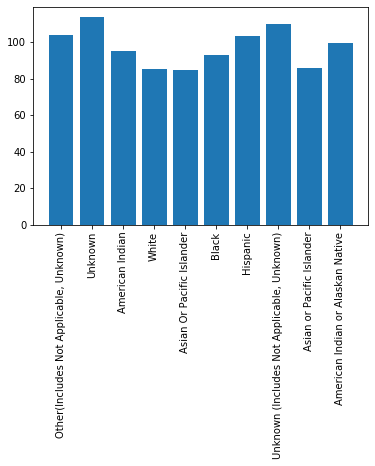

In [70]:
plt.bar(fines_pd['Race'], fines_pd['avg(Fine)'])
plt.xticks(rotation=90)
plt.show()

Whites have the lowest average fine of any racial group.

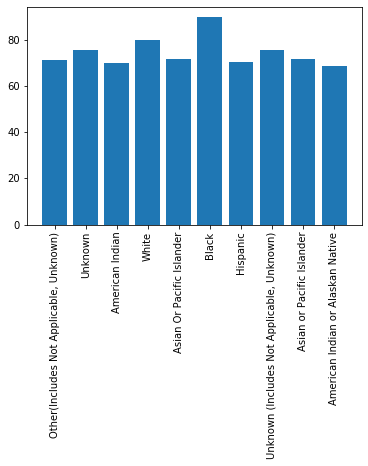

In [71]:
plt.bar(fines_pd['Race'], fines_pd['avg(Costs)'])
plt.xticks(rotation=90)
plt.show()